In [1]:
import altair as alt
import numpy as np
import pandas as pd
from scipy.stats import loguniform
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve
)
from sklearn.model_selection import (
    cross_validate, RandomizedSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder
)

In [2]:
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [3]:
# Read Data
train_df = pd.read_csv("../data/preprocessed/clean_train.csv")
test_df = pd.read_csv("../data/preprocessed/clean_test.csv")


# Transform native_country into binary
train_df['native_country'] = train_df['native_country'] == 'United-States'
test_df['native_country'] = test_df['native_country'] == 'United-States'

# Set positive label to ">50K", which is the class with smaller proportion
train_df['income'] = train_df['income'] == '>50K'
test_df['income'] = test_df['income'] == '>50K'

In [4]:
# Split data into features & target
X_train = train_df.drop("income", axis=1)
y_train = train_df['income']
X_test = test_df.drop("income", axis=1)
y_test = test_df['income']

In [5]:
# Preprocessing
numeric_feats = ['age', 'fnlwgt', 'hours_per_week']
categorical_null_feats = ['workclass', "occupation"]
categorical_nonull_feats = ["marital_status", "relationship"]

binary_feats = ['sex', 'native_country']
passthrough_feats = ['education_num']
drop_feats = ['education', 'race', 'capital_gain', 'capital_loss']

col_trans = make_column_transformer(
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(sparse=False, handle_unknown='ignore', drop=[np.nan] * 2), categorical_null_feats),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_nonull_feats),
    (OneHotEncoder(drop='if_binary'), binary_feats),
    ('passthrough', passthrough_feats),
    ('drop', drop_feats)
)

In [6]:
# Calculate Baseline Performances
scoring = ['accuracy', 'precision', 'recall', 'f1']
results = {}
pipe_dummy = make_pipeline(
    col_trans,
    DummyClassifier()
)
results['DummyClassifier'] = pd.DataFrame(cross_validate(pipe_dummy, X_train, y_train, scoring=scoring)).mean()

# Calculate Baseline Perfromance for Random Forest Classifier
pipe_forest = make_pipeline(
    col_trans,
    RandomForestClassifier(random_state=522)
)
results['RandomForest_default'] = pd.DataFrame(cross_validate(pipe_forest, X_train, y_train, scoring=scoring)).mean()

/home/philschan/miniconda3/envs/census-income/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/philschan/miniconda3/envs/census-income/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/philschan/miniconda3/envs/census-income/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/philschan/miniconda

In [7]:
pd.DataFrame(results)

,DummyClassifier,RandomForest_default
fit_time,0.050029,2.162239
score_time,0.021410,0.148352
test_accuracy,0.759190,0.827278
test_precision,0.000000,0.667138
test_recall,0.000000,0.564342
test_f1,0.000000,0.611435


In [8]:
param_dist = {
    "randomforestclassifier__class_weight": [None, "balanced"],
    "randomforestclassifier__n_estimators": [10, 20, 50, 100, 200, 500],
    "randomforestclassifier__max_depth": np.arange(10, 20, 2)
}
rand_search_rf = RandomizedSearchCV(pipe_forest, param_dist, n_iter=20, 
                                    random_state=952, scoring=scoring, refit="accuracy")

rand_search_rf.fit(X_train, y_train);

In [9]:
hyperparam_result = pd.DataFrame(
    rand_search_rf.cv_results_
).sort_values("rank_test_accuracy")[['param_randomforestclassifier__n_estimators',
                                     'param_randomforestclassifier__max_depth',
                                     'param_randomforestclassifier__class_weight',
                                     'mean_test_accuracy',
                                     'mean_test_precision',
                                     'mean_test_recall',
                                     'mean_test_f1',
                                    ]]
hyperparam_result

,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,param_randomforestclassifier__class_weight,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
5,50,14,None,0.840331,0.724261,0.544830,0.621745
15,500,18,None,0.840331,0.714309,0.562046,0.629031
1,50,18,None,0.840023,0.712278,0.563831,0.629317
12,100,14,None,0.839747,0.723995,0.541258,0.619334
0,50,16,None,0.839440,0.716106,0.552481,0.623699
4,20,14,None,0.839225,0.720737,0.543427,0.619484
9,500,12,None,0.838365,0.731105,0.520470,0.607991
8,100,10,None,0.835877,0.734925,0.498280,0.593839
17,10,12,None,0.835755,0.715622,0.527740,0.607455
13,20,10,None,0.835478,0.731716,0.500573,0.594390


In [10]:
# Evaluate Model with test data set
y_pred_train = rand_search_rf.predict(X_train)
y_pred = rand_search_rf.predict(X_test)

In [11]:
# Table of Metrics
model_perf_df = pd.DataFrame(
    {
        "Accuarcy": [accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred)],
        "Precision": [precision_score(y_train, y_pred_train), precision_score(y_test, y_pred)],
        "Recall": [recall_score(y_train, y_pred_train), recall_score(y_test, y_pred)],
        "F1 Score": [f1_score(y_train, y_pred_train), f1_score(y_test, y_pred)]
    },
    index=["Train Data", "Test Data"])
model_perf_df

,Accuarcy,Precision,Recall,F1 Score
Train Data,0.877768,0.816113,0.635633,0.714654
Test Data,0.842332,0.721051,0.542382,0.619083


In [12]:
PR_curve_df = pd.DataFrame(precision_recall_curve(y_train, rand_search_rf.predict_proba(X_train)[:,1],), index=["precision","recall","threshold"]).T
PR_curve_df['F1 Score'] =  2 * (PR_curve_df['precision'] * PR_curve_df['recall'])/(PR_curve_df['precision'] + PR_curve_df['recall'])
PR_curve_df

,precision,recall,threshold,F1 Score
0,0.356587,1.000000,0.031877,0.525712
1,0.356558,0.999872,0.031882,0.525663
2,0.356574,0.999872,0.031887,0.525681
3,0.356591,0.999872,0.031887,0.525698
4,0.356607,0.999872,0.031897,0.525716
...,...,...,...,...
20798,1.000000,0.000510,0.946247,0.001020
20799,1.000000,0.000383,0.951960,0.000765
20800,1.000000,0.000255,0.953926,0.000510
20801,1.000000,0.000128,0.954158,0.000255


In [13]:
# Threshold to get best F1 score
max_f1_df = PR_curve_df.iloc[PR_curve_df["F1 Score"].idxmax()].to_frame().T
best_thres = max_f1_df['threshold'].iloc[0]
max_f1_df

,precision,recall,threshold,F1 Score
12051,0.701227,0.838413,0.365243,0.763708


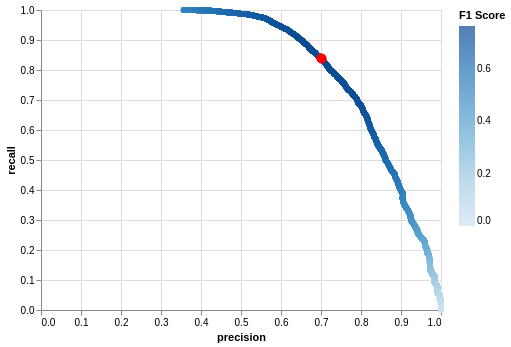

In [14]:
PR_curve_plot = alt.Chart(PR_curve_df).mark_circle().encode(
    x="precision",
    y="recall",
    color="F1 Score"
)
max_f1_point = alt.Chart(max_f1_df).mark_circle(color="red", size=100, opacity=1).encode(
    x="precision",
    y="recall",
)
PR_curve_plot + max_f1_point

In [15]:
# Evaluate Model with test data set with best_thres
y_pred_train_thres = rand_search_rf.predict_proba(X_train)[:, 1] > best_thres
y_pred_thres = rand_search_rf.predict_proba(X_test)[:, 1] > best_thres

In [16]:
# Table of Metrics with best_thres
model_perf_thres_df = pd.DataFrame(
    {
        "Accuarcy": [accuracy_score(y_train, y_pred_train_thres), accuracy_score(y_test, y_pred_thres)],
        "Precision": [precision_score(y_train, y_pred_train_thres), precision_score(y_test, y_pred_thres)],
        "Recall": [recall_score(y_train, y_pred_train_thres), recall_score(y_test, y_pred_thres)],
        "F1 Score": [f1_score(y_train, y_pred_train_thres), f1_score(y_test, y_pred_thres)]
    },
    index=["Train Data w/ best threshold", "Test Data w/ best threshold"])

In [17]:
pd.concat([model_perf_df, model_perf_thres_df])

,Accuarcy,Precision,Recall,F1 Score
Train Data,0.877768,0.816113,0.635633,0.714654
Test Data,0.842332,0.721051,0.542382,0.619083
Train Data w/ best threshold,0.875035,0.701195,0.838286,0.763636
Test Data w/ best threshold,0.823967,0.605832,0.729329,0.661869


In [18]:
# TODO: Confusion Matrix, ROC Curve, Other Data Viz